# Cosmic Neighbours

In this project we are adding a time dimension to the famous [Drake Equation](https://en.wikipedia.org/wiki/Drake_equation). The Drake Equation is as follows:
    
#### N = Rs * fp * ne * fl * fi * fc * L
    where:
    N = number of civilizations with which humans could communicate
    Rs = mean rate of star formation
    fp = fraction of stars that have planets
    ne = mean number of planets that could support life per star with planets
    fl = fraction of life-supporting planets that develop life
    fi = fraction of planets with life where life develops intelligence
    fc = fraction of intelligent civilizations that develop communication
    L = mean length of time that civilizations can communicate
    
This solution to the number of civilizations is a steady state solution. Meaning, we cannot use this estimate to estimate the number of extict civilizations in our galaxy. And it assumes that the intelligent population of the galaxy is not growing. I will try to answer these questions by adding a time dimension to the calcuation.


### Imports

In [1]:
# import custom functions from drakefunctions.py
from drakefunctions import *

In [2]:
# import modules

import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:_.0f}'.format)
from scipy.stats import poisson
from scipy.special import gamma  # not the one from scipy.stats
from math import factorial, exp, log
import datetime, time
from decimal import *

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
%matplotlib inline
mpl.rcParams["axes.formatter.min_exponent"] = 20  # no scientific notation in graphs
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 10   # pad is in points... default is 6
import seaborn as sns
sns.set_theme()

### CONSTANTS (and pseudo-constants$^{ [1]}$)
\[1] "Pseudo-constants" are (probably) constants that we don't know very well. We will start by making best-guess assumptions, and we will evaluate these pseudo-constants in detail later using Monte Carlo simulation.

In [3]:
# CONSTANTS treated as variables for simulation

# inputs to the Drake equation
default_params = dict(
    # time step increments for calculations
    YEAR_STEPS = 1_000_000,
    # galactic attributes
    NUM_GALAXY = 100_000_000_000,  # number of stars in a galaxy
    GALAXY_RADIUS_LYR = 50_000,  # radius of the galaxy in lightyears
    MODERN_ERA = 10_000_000_000,  # years since 2nd gen stars, order of magnitude approx
    # pseudo-constants (treated as constants until Monte Carlo simulation)
    RS = 2, 
    FP = 1, 
    NE = 0.4, 
    FL = 1, 
    FI = 1, 
    FC = 0.1, 
    L = 1000,
    YEARS_PLANETS_TO_HABITABLE = 2_000_000_000, 
    YEARS_HABITABLE_TO_LIFE = 1_000_000_000, 
    YEARS_LIFE_TO_COMPLEX_LIFE = 1_000_000_000, 
    YEARS_COMPLEX_TO_INTELLIGENCE = 200_000_000, 
    YEARS_INTELLIGENCE_TO_CULTURE = 20_000_000, 
    YEARS_CULTURE_TO_TECH = 200_000, 
    EXTINCTION_SIMPLE = 5_000_000_000, 
    EXTINCTION_COMPLEX = 2_000_000_000, 
    EXTINCTION_INTELLIGENT = 200_000_000, 
    EXTINCTION_CULTURAL = 1_000_000, 
    # EXTINCTION_TECHNOLOGICAL = L,
    WEIBULL_SHAPE_PARAMETER = 0.4,  # k
    WEIBULL_SCALE_PARAMETER = 20_000  # lambda    
)

random_params = dict(
    # time step increments for calculations
    YEAR_STEPS = [1_000_000],
    # galactic attributes
    NUM_GALAXY = [100_000_000_000],  # number of stars in a galaxy
    GALAXY_RADIUS_LYR = [50_000],  # radius of the galaxy in lightyears
    MODERN_ERA = [10_000_000_000],  # years since 2nd gen stars, order of magnitude approx
    # pseudo-constants (treated as constants until Monte Carlo simulation)
    RS = [1, 2, 3],
    FP = [0.05, 0.2, 0.5, 1.0, 2.0],
    NE = [0.02, 0.1, 0.4, 1.0],
    FL = [0.01, 0.1, 1],
    FI = [0.01, 0.1, 1],
    FC = [0.01, 0.1, 1],
    L = [100, 1_000, 10_000, 100_000, 1_000_000],
    YEARS_PLANETS_TO_HABITABLE = [1_000_000_000, 2_000_000_000, 3_000_000_000], 
    YEARS_HABITABLE_TO_LIFE = [100_000_000, 1_000_000_000, 5_000_000_000], 
    YEARS_LIFE_TO_COMPLEX_LIFE = [100_000_000, 1_000_000_000, 5_000_000_000, 10_000_000_000], 
    YEARS_COMPLEX_TO_INTELLIGENCE = [100_000, 1_000_000, 50_000_000, 200_000_000, 1_000_000_000], 
    YEARS_INTELLIGENCE_TO_CULTURE = [10_000, 100_000, 2_000_000, 20_000_000, 200_000_000], 
    YEARS_CULTURE_TO_TECH = [1_000, 10_000, 100_000, 200_000, 2_000_000], 
    EXTINCTION_SIMPLE = [200_000_000, 1_000_000_000, 2_000_000_000, 5_000_000_000],  # these are mass extinction events
    EXTINCTION_COMPLEX = [200_000_000, 1_000_000_000, 2_000_000_000], # these are mass extinction events
    EXTINCTION_INTELLIGENT = [10_000, 100_000, 1_000_000, 10_000_000, 200_000_000, 1_000_000_000], 
    EXTINCTION_CULTURAL = [1_000, 10_000, 100_000, 1_000_000, 10_000_000], 
    # EXTINCTION_TECHNOLOGICAL = L,
    WEIBULL_SHAPE_PARAMETER = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # k
    WEIBULL_SCALE_PARAMETER = [100, 250, 500, 750, 1000, 5_000, 10_000, 20_000, 50_000, 100_000]  # lambda
)


In [4]:
# initialise params
params = params_set(default_params)

In [5]:
# testing
# params_rand(random_params)

In [6]:
# testing
# params_set(default_params)

In [7]:
params

{'YEAR_STEPS': 1000000,
 'NUM_GALAXY': 100000000000,
 'GALAXY_RADIUS_LYR': 50000,
 'MODERN_ERA': 10000000000,
 'RS': 2,
 'FP': 1,
 'NE': 0.4,
 'FL': 1,
 'FI': 1,
 'FC': 0.1,
 'L': 1000,
 'YEARS_PLANETS_TO_HABITABLE': 2000000000,
 'YEARS_HABITABLE_TO_LIFE': 1000000000,
 'YEARS_LIFE_TO_COMPLEX_LIFE': 1000000000,
 'YEARS_COMPLEX_TO_INTELLIGENCE': 200000000,
 'YEARS_INTELLIGENCE_TO_CULTURE': 20000000,
 'YEARS_CULTURE_TO_TECH': 200000,
 'EXTINCTION_SIMPLE': 5000000000,
 'EXTINCTION_COMPLEX': 2000000000,
 'EXTINCTION_INTELLIGENT': 200000000,
 'EXTINCTION_CULTURAL': 1000000,
 'WEIBULL_SHAPE_PARAMETER': 0.4,
 'WEIBULL_SCALE_PARAMETER': 20000}

### The Original Drake Equation

In [8]:
# Using our best estimates, the Drake Equation predicts...

Drake(params)

80

In [9]:
# hack the Drake equation to estimate how many extict technological civilizations
# might exist in the Milky Way
immortal = params.copy()
immortal['L'] = 15_000_000_000
print(f"{Drake(immortal):,}")
# seems way too high...

1,200,000,000


### The Time-Dependent Drake Equation

In [10]:
%%time
history_of_life = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=0.9)

history_of_life.tail()

Wall time: 15.7 s


,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
9996000000,95_039_003_081,38_015_601_233,36_963_131_775,35_349_216_742,22_739_909_023,11_328_440_917,704_431_474,101_956_517,519_514_241_735
9997000000,95_039_102_301,38_015_640_921,36_963_658_010,35_350_086_706,22_740_677_473,11_328_840_529,704_456_337,101_960_117,519_616_198_252
9998000000,95_039_201_519,38_015_680_608,36_964_184_001,35_350_956_308,22_741_445_626,11_329_239_987,704_481_189,101_963_715,519_718_158_369
9999000000,95_039_300_735,38_015_720_294,36_964_709_749,35_351_825_549,22_742_213_480,11_329_639_292,704_506_033,101_967_312,519_820_122_084
10000000000,95_039_399_949,38_015_759_980,36_965_235_255,35_352_694_429,22_742_981_037,11_330_038_443,704_530_866,101_970_908,519_922_089_396


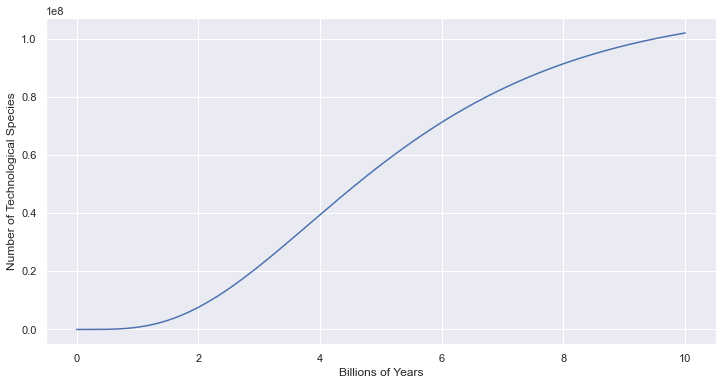

In [11]:
# plot of technological species over time

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=history_of_life.index/1_000_000_000, y=history_of_life.N);
plt.yticks(rotation=0);
plot.set_ylabel('Number of Technological Species');
plot.set_xlabel('Billions of Years');

# QA UPDATES TO POISSON FUNCTION

In [12]:
history_of_life.to_csv('history_of_life_10B_yr.csv')

### is Poisson working properly?
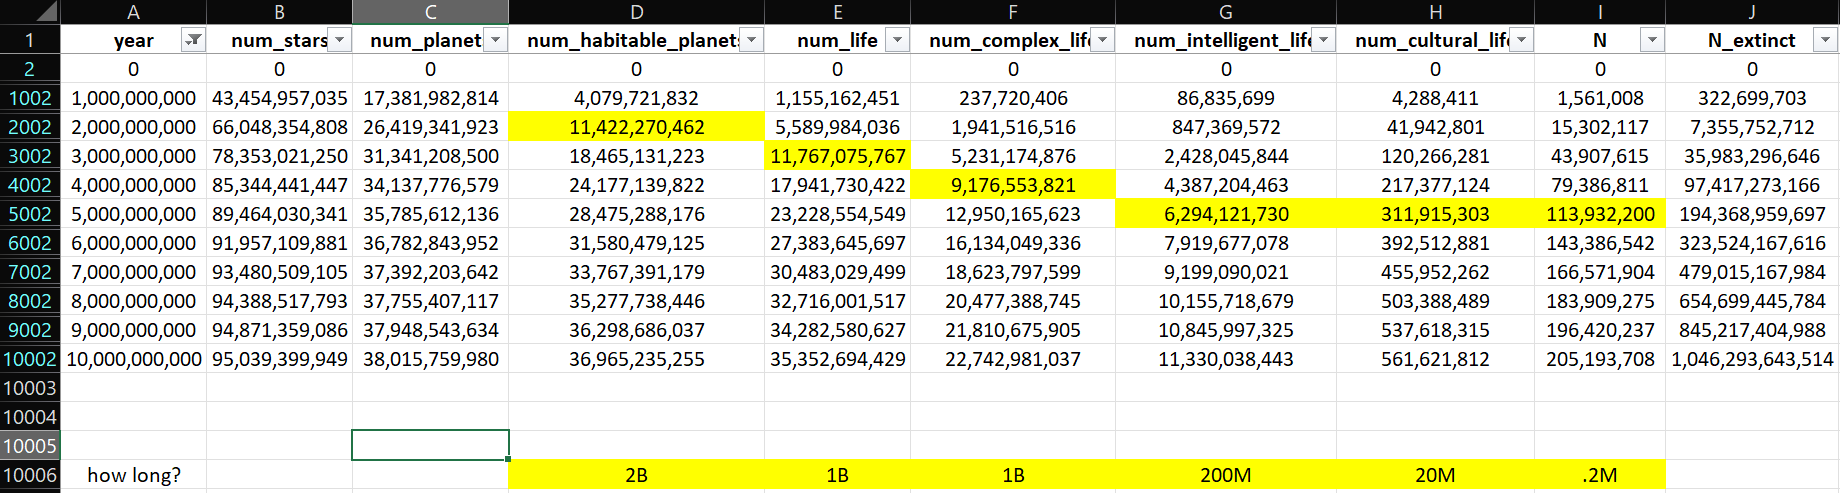

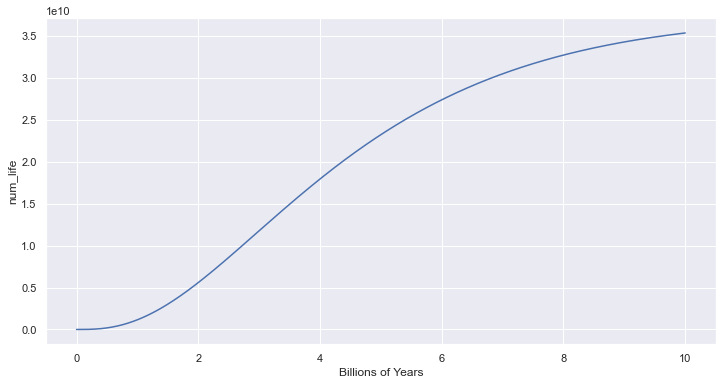

In [89]:
# plot of
series = history_of_life[list(history_of_life.columns)[3]]

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=history_of_life.index/1_000_000_000, y=series);
plt.yticks(rotation=0);
plot.set_xlabel('Billions of Years');

In [73]:
# transition(params, num_from, num_to, prob_of_transition)
num_from, num_to = 1_000_000, 0
prob_of_transition = params['YEARS_PLANETS_TO_HABITABLE']

# probability, avg yrs
prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
print(f"{prob_of_transition:_.0f} years per transition on average")

# percent that transition over 1B years
output = 0
for i in range(1000):
    output += prob_transition * (1 - output)
    
print(f"{output*100:_.0f}% chance of transition over 1B years")

0.0500% chance of transition over 1M years
2_000_000_000 years per transition on average
39% chance of transition over 1B years


In [67]:
# transition(params, num_from, num_to, prob_of_transition)
num_from, num_to = 1_000_000, 0
prob_of_transition = params['YEARS_HABITABLE_TO_LIFE']

# probability, avg yrs
prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
print(f"{prob_of_transition:_.0f} years per transition on average")

# percent that transition over 1B years
output = 0
for i in range(1000):
    output += prob_transition * (1 - output)
    
print(f"{output*100:_.0f}% chance of transition over 1B years")

0.1000% chance of transition over 1B years
1_000_000_000 years per transition on average
63% chance of transition over 1B years


In [69]:
# transition(params, num_from, num_to, prob_of_transition)
num_from, num_to = 1_000_000, 0
prob_of_transition = params['YEARS_LIFE_TO_COMPLEX_LIFE']

# probability, avg yrs
prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
print(f"{prob_of_transition:_.0f} years per transition on average")

# percent that transition over 1B years
output = 0
for i in range(1000):
    output += prob_transition * (1 - output)
    
print(f"{output*100:_.0f}% chance of transition over 1B years")

0.1000% chance of transition over 1M years
1_000_000_000 years per transition on average
63% chance of transition over 1B years


In [70]:
# transition(params, num_from, num_to, prob_of_transition)
num_from, num_to = 1_000_000, 0
prob_of_transition = params['YEARS_COMPLEX_TO_INTELLIGENCE']

# probability, avg yrs
prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
print(f"{prob_of_transition:_.0f} years per transition on average")

# percent that transition over 1B years
output = 0
for i in range(1000):
    output += prob_transition * (1 - output)
    
print(f"{output*100:_.0f}% chance of transition over 1B years")

0.4988% chance of transition over 1M years
200_000_000 years per transition on average
99% chance of transition over 1B years


In [71]:
# transition(params, num_from, num_to, prob_of_transition)
num_from, num_to = 1_000_000, 0
prob_of_transition = params['YEARS_INTELLIGENCE_TO_CULTURE']

# probability, avg yrs
prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
print(f"{prob_of_transition:_.0f} years per transition on average")

# percent that transition over 1B years
output = 0
for i in range(1000):
    output += prob_transition * (1 - output)
    
print(f"{output*100:_.0f}% chance of transition over 1B years")

4.8771% chance of transition over 1M years
20_000_000 years per transition on average
100% chance of transition over 1B years


In [72]:
# transition(params, num_from, num_to, prob_of_transition)
num_from, num_to = 1_000_000, 0
prob_of_transition = params['YEARS_CULTURE_TO_TECH']

# probability, avg yrs
prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
print(f"{prob_of_transition:_.0f} years per transition on average")

# percent that transition over 1B years
output = 0
for i in range(1000):
    output += prob_transition * (1 - output)
    
print(f"{output*100:_.0f}% chance of transition over 1B years")

99.3262% chance of transition over 1M years
200_000 years per transition on average
100% chance of transition over 1B years


In [20]:
num = 1_000_000

extinction_simple, extinction_complex, extinction_intelligent, extinction_cultural, extinction_technological = new_extinctions(
    params, 
    num_stars=100_000_000_000, 
    num_life=num, 
    num_complex_life=num, 
    num_intelligent_life=num, 
    num_cultural_life=num, 
    N=num
)

extinction_simple/num, extinction_complex/num, extinction_intelligent/num, extinction_cultural/num, extinction_technological/num

(1.99999999998e-05,
 0.0005198750208305296,
 0.005007520807317488,
 0.6321405588285575,
 1.0)

# TEST YEAR STEPS

In [21]:
def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * prob_poisson(params['YEARS_CULTURE_TO_TECH'], params['YEAR_STEPS'])

In [22]:
# reset
params['YEAR_STEPS'] = 1_000_000

In [23]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# 99% of cultuures evolve technology over 1M yr

0.9932620530009145

In [24]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing GOOD - this ratio is commutatitve

(0.9932620530009145, 0.3934693402873665)

In [25]:
def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * params['FC'] * prob_poisson(params['YEARS_CULTURE_TO_TECH'], params['YEAR_STEPS'])

In [26]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# % of cultuures evolve technology over 1M yr

0.09932620530009145

In [27]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing BAD, not commutative anymore, because of FC factor

(0.33063078988391387, 0.03934693402873665)

In [28]:
# reset
params['YEAR_STEPS'] = 1_000_000

In [75]:
# USE THIS ONE

def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * prob_poisson(params['YEARS_CULTURE_TO_TECH'] / params['FC'], params['YEAR_STEPS'])

In [30]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# % of cultuures evolve technology over 1M yr

0.3934693402873665

In [31]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing GOOD AGAIN, now commutative and uses FC

(0.3934693402873665, 0.048770575499285984)

In [32]:
# reset
params['YEAR_STEPS'] = 1_000_000

##### compare values of YEAR_STEPS 
    complex or higher are not working 
    num_life or higher are inconsistent with old odds calcs

In [82]:
%%time
params['YEAR_STEPS'] = 10_000_000
tech_dominance_0 = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

tech_dominance_0.tail()

Wall time: 1.53 s


,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
9960000000,95_049_310_897,38_019_724_359,36_956_349_231,35_331_631_432,22_765_440_925,11_538_831_259,4_316_514_984,-707_253,-374_811_412
9970000000,95_050_301_035,38_020_120_414,36_961_666_107,35_340_437_238,22_773_246_725,11_542_969_200,4_318_069_449,-707_500,-375_518_666
9980000000,95_051_290_975,38_020_516_390,36_966_958_378,35_349_206_571,22_781_022_336,11_547_091_276,4_319_617_958,-707_745,-376_226_165
9990000000,95_052_280_717,38_020_912_287,36_972_226_168,35_357_939_557,22_788_767_852,11_551_197_536,4_321_160_531,-707_989,-376_933_910
10000000000,95_053_270_261,38_021_308_104,36_977_469_599,35_366_636_320,22_796_483_365,11_555_288_028,4_322_697_186,-708_233,-377_641_900


In [83]:
%%time
params['YEAR_STEPS'] = 100_000_000
tech_dominance_0 = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

tech_dominance_0.tail()

Wall time: 176 ms


,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
9600000000,95_155_520_978,38_062_208_391,36_880_011_661,35_132_996_853,22_982_710_236,13_460_390_175,8_062_119_156,-16_869_224,-777_640_929
9700000000,95_165_209_936,38_066_083_974,36_939_121_498,35_232_431_096,23_074_012_901,13_517_594_401,8_097_860_038,-16_945_142,-794_510_153
9800000000,95_174_879_516,38_069_951_806,36_995_469_621,35_327_845_681,23_161_871_909,13_572_666_651,8_132_278_718,-17_018_530,-811_455_295
9900000000,95_184_529_757,38_073_811_903,37_049_193_731,35_419_367_985,23_246_391_793,13_625_671_287,8_165_414_699,-17_089_128,-828_473_825
10000000000,95_194_160_697,38_077_664_279,37_100_424_639,35_507_126_121,23_327_674_420,13_676_670_940,8_197_306_703,-17_157_021,-845_562_954


In [84]:
%%time
params['YEAR_STEPS'] = 1_000_000
tech_dominance_0 = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

tech_dominance_0.tail()

Wall time: 15.7 s


,num_stars,num_planets,num_habitable_planets,num_life,num_complex_life,num_intelligent_life,num_cultural_life,N,N_extinct
year,,,,,,,,,
9996000000,95_039_003_081,38_015_601_233,36_963_131_775,35_349_216_742,22_739_909_023,11_328_440_917,691_604_021,100_099_924,510_056_010_622
9997000000,95_039_102_301,38_015_640_921,36_963_658_010,35_350_086_706,22_740_677_473,11_328_840_529,691_628_430,100_103_458,510_156_110_545
9998000000,95_039_201_519,38_015_680_608,36_964_184_001,35_350_956_308,22_741_445_626,11_329_239_987,691_652_830,100_106_991,510_256_214_004
9999000000,95_039_300_735,38_015_720_294,36_964_709_749,35_351_825_549,22_742_213_480,11_329_639_292,691_677_220,100_110_523,510_356_320_995
10000000000,95_039_399_949,38_015_759_980,36_965_235_255,35_352_694_429,22_742_981_037,11_330_038_443,691_701_602,100_114_053,510_456_431_518


# How to interpret these averages/expectations given 1M yr time steps

These numbers are based on the active instances over 1M year time steps. This isn't significant for values with slower
extinction values, but with N, these predictions are misleading. E.g., 100 technological species seems like
a lot, but if that's over 1M years, and they each survive 1k yr, there is less than 1 on average at the same time.

We need to convert these numbers into probabilities / histograms to gain insight into how likely we are to find life. 

In [ ]:
# number of technological lifeforms in 1M yr timestep at end of Drake calculation
N_1M_yr = int(round(history_of_life.iloc[[-1]].N))
N_1M_yr

In [ ]:
%%time

active_each_year = breakdown_by_year(params, N_1M_yr)

In [ ]:
percentage_table(active_each_year)

In [ ]:
plot_histogram(active_each_year, discrete=True)

In [ ]:
%%time
# hypothetical large number of technological lifeforms active in 1M yr timestep

# TESTING
N_large = 1_000
# histogram starts getting messy at 1k+, can't bin it easily because it's actually a barplot

active_each_year_large = breakdown_by_year(params, N_large)

In [ ]:
plot_histogram(active_each_year_large)

# implications of tech_dominance

In [ ]:
%%time
tech_dominance_1 = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

tech_dominance_1.tail()

In [ ]:
plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=tech_dominance_1.index/1_000_000_000, y=tech_dominance_1.N);
plt.yticks(rotation=0);
plot.set_ylabel('Number of Technological Species');
plot.set_xlabel('Billions of Years');

In [ ]:
%%time
tech_dominance_0 = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=0)

tech_dominance_0.tail()

In [ ]:
plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=tech_dominance_0.index/1_000_000_000, y=tech_dominance_0.N);
plt.yticks(rotation=0);
plot.set_ylabel('Number of Technological Species');
plot.set_xlabel('Billions of Years');

# steady state values
    what are steady state values?
    when will we reach approx steady state?
    can we match the time-invariant Drake Equation?

In [ ]:
%%time
# couldn't think of an algorithm that wouldn't take forever, so I brute-forced and grit
# should come up with an automated way to check different settings
P_tech_dominance = 0.9

index = 'year'
columns = ['year', 'num_stars', 'num_planets', 'num_habitable_planets', 'num_life', 
       'num_complex_life', 'num_intelligent_life', 'num_cultural_life', 'N', 'N_extinct']

steady_state = pd.DataFrame(
    [[0, 100_000_000_000, 40_000_000_000, 40_000_000_000, 974_975_916, 23_619_997, 6_551_317, 8_796, 6_262, 0]], 
    columns = columns,
    index=[0]
).set_index(index)

for i in range(2):
    temp_df = TimeDependentDrake(params, 10_000_000_000*(i+1), P_tech_dominance, df_input=steady_state)
    steady_state = steady_state.append(temp_df.iloc[[-1]])
    
# print(steady_state.iloc[-1]-steady_state.iloc[0])
# print()
steady_state.tail()

In [ ]:
plot_histogram(breakdown_by_year(params, 6_262), binwidth=5)

In [ ]:
how_far(params, 400)

### Are these calculations equivalent to the orignial Drake Equation?

In [ ]:
match_simulation = params.copy()
match_simulation['L'] = 5_000
Drake(match_simulation)
# this is within the range of estimates used in the prob_L() function, and 1k < L < 1M from current guesses

In [ ]:
int(weibull_mean(params))

In [ ]:
int(weibull_median(params))  # not exactly 5000

Statistics Notes

mode is 0, because k < 0

Results not the same for the same L, but could be equivalent
    
    our mean > mode > original L
        there are a very large number of short-lived species
    let's check with a quick simulation
    we could also rerun using L constant or poisson to see if it gives the same results
    we have more forms of extinction (simple, complex, intelligent, etc)
        this slows down life formation, could account for the discrepancy

In [ ]:
# simulation of prob_L

temp_list = []
temp_steps = 1_000

for i in range(1_000):
    temp_list.append([temp_steps * i, 1 - prob_L(params, temp_steps * i)])

df = pd.DataFrame(temp_list, columns=['Years', 'Prob_Survival'])

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=df['Years'], y=df['Prob_Survival']);
# plot.set(xscale='log');
plot.set_ylabel('Probability of Survival');
plt.ticklabel_format(style='plain', axis='x')
# plot.set_xlabel('Years');

In [ ]:
# simulation of prob_L

temp_list = []
temp_steps = 10

for i in range(1_000):
    temp_list.append([temp_steps * i, 1 - prob_L(params, temp_steps * i)])

df = pd.DataFrame(temp_list, columns=['Years', 'Prob_Survival'])

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=df['Years'], y=df['Prob_Survival']);
# plot.set(xscale='log');
plot.set_ylabel('Probability of Survival');
plt.ticklabel_format(style='plain', axis='x')
# plot.set_xlabel('Years');

In [ ]:
pd.set_option('display.float_format', '{:_.2f}'.format)
df.head(10)
# 10% of species are extinct at 70 years

In [ ]:
# reset pandas format
pd.set_option('display.float_format', '{:_.0f}'.format)

# distance to closest species
#TODO: could make a formula to calculate the odds that there is x within y

In [ ]:
# closest living technological life
# most likely we're alone in the galaxy, but there could be 1 or 2, so
how_far(params, 1)

In [ ]:
# likely max 2 other species
how_far(params, 2)

In [ ]:
# steady state solution ~400 tech species
how_far(params, 400)

##### Control Problem?

In [ ]:
# closest extinct technological species
# current year, with P_tech_dominance 0 or 1
how_far(params, 10_000), how_far(params, 40_000)

In [ ]:
# how many stars within 700 lyr?
stars_within(724.6)
# we'd probably notice 2.5M stars being converted into paperclips
# we should at least be able to detect a runaway AI

In [ ]:
ai_propagation_speed_low = 0.0001  # percentage of the speed of light that superintelligent AI can travel
ai_propagation_speed_high = 0.01  # percentage of the speed of light that superintelligent AI can travel
chance_of_control_problem_low = 0.01  # proportion of extinctions due to runaway paperclip optimiser
chance_of_control_problem_high = 0.1  # proportion of extinctions due to runaway stamp collector

# years for rogue AI to travel here
pd.DataFrame(
    [[how_far(params, 11_000 * chance_of_control_problem_low) / ai_propagation_speed_low, 
      how_far(params, 11_000 * chance_of_control_problem_high) / ai_propagation_speed_high
    ]], columns=['Years Until Invasion - High', 'Years Until Invasion - Low']
)

In [ ]:
# plot of extinct technological species over time

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=history_of_life.index/1_000_000, y=history_of_life.N_extinct);

plot.set(xlim=(9_900, 10_000),ylim=(10_800, 11_500));
plt.yticks(rotation=0);
plot.set_ylabel('Number of Extinct Technological Species');
plot.set_xlabel('Millions of Years');

In [ ]:
# kind of seems like we should have been converted into paperclips by now...
# i feel like we'll notice before 10k lyr**2 of stars were converted to paperclips, but you never know

In [ ]:
# how close are the closest paperclip monsters
how_far(params, 11_000 * chance_of_control_problem_low), how_far(params, 11_000 * chance_of_control_problem_high)

In [ ]:
# how many stars within 2664 lyr?
stars_within(2664.0)
# we'd very likely notice 90M stars being converted into stamps

**we should have plenty of notice**

    unless we mistake rogue AI for very common astrophysical phemomena 

# LONGER CALCULATIONS

# implications of longer time values (eg, 1T yr, steady state, etc)

In [ ]:
%%time
#TODO: haven't tested this as a function yet...
#TODO: write a loop to save csv in 10B yr increments
# combine csv
    # eg, history_of_life.to_csv('history_of_life_1T_yr.csv')  # or nested path
# plot it

epoch_steps = 1_000_000_000
final_year = 100_000_000_000
P_tech_dominance = 0.9

future_of_life = long_time(params, epoch_steps, final_year, P_tech_dominance = 0.9)

# for 10B yr: 12s 
# for 100B yr: 124s
# for 1T yr: estimate 1240s = 21min
future_of_life.tail()

# Monte Carlo Simulation

In [ ]:
#TODO: redo this section with more flexibility, saving into folders, csv functions

In [ ]:
# test randomisation
randomise_constants(drake_range, timeframes_range)
df1 = pd.DataFrame([RS, FP, NE, FL, FI, FC, L, YEARS_PLANETS_TO_HABITABLE, YEARS_HABITABLE_TO_LIFE, YEARS_LIFE_TO_COMPLEX_LIFE, YEARS_COMPLEX_TO_INTELLIGENCE, YEARS_INTELLIGENCE_TO_CULTURE, YEARS_CULTURE_TO_TECH, EXTINCTION_SIMPLE, EXTINCTION_COMPLEX, EXTINCTION_INTELLIGENT, EXTINCTION_CULTURAL, WEIBULL_SHAPE_PARAMETER, WEIBULL_SCALE_PARAMETER])
reset_default_constants(drake_best, timeframes_best)
df2 = pd.DataFrame([RS, FP, NE, FL, FI, FC, L, YEARS_PLANETS_TO_HABITABLE, YEARS_HABITABLE_TO_LIFE, YEARS_LIFE_TO_COMPLEX_LIFE, YEARS_COMPLEX_TO_INTELLIGENCE, YEARS_INTELLIGENCE_TO_CULTURE, YEARS_CULTURE_TO_TECH, EXTINCTION_SIMPLE, EXTINCTION_COMPLEX, EXTINCTION_INTELLIGENT, EXTINCTION_CULTURAL, WEIBULL_SHAPE_PARAMETER, WEIBULL_SCALE_PARAMETER])
pd.concat([df1, df2], axis=1)

### Simulations

##### Original Drake Equation

In [ ]:
%%time

simulation = []

for i in range(1_000_000):
    randomise_constants(drake_range, timeframes_range)
    simulation.append(Drake(RS, FP, NE, FL, FI, FC, L))

reset_default_constants(drake_best, timeframes_best)

pd.DataFrame(simulation).describe()

In [ ]:
# confirm that defaults are reset
Drake(RS, FP, NE, FL, FI, FC, L)  # defaults lead to 80

##### Time Dependent Drake

In [ ]:
%%time

output_year = 1_000_000_000
simulation2 = []

for i in range(10):
    randomise_constants(drake_range, timeframes_range)
    N_temp = TimeDependentDrake(output_year=output_year, P_tech_dominance=np.random.random())['N']
    simulation2.append(N_temp.iloc[-1])

reset_default_constants(drake_best, timeframes_best)

pd.DataFrame(simulation2)
# pd.DataFrame(simulation2).describe()

In [ ]:
pd.set_option('display.float_format', '{:_.0f}'.format)

In [ ]:
%%time

output_year = 1_000_000_000
simulation2 = pd.DataFrame()

for i in range(100):
    randomise_constants(drake_range, timeframes_range)
    df_temp = TimeDependentDrake(output_year=output_year, P_tech_dominance=np.random.random())
    simulation2 = simulation2.append(df_temp.iloc[-1])

reset_default_constants(drake_best, timeframes_best)


In [ ]:
simulation2.describe()

In [ ]:
pd.set_option('display.max_rows', 100)
simulation2

1M years, 100 trials -> 2min 38s
trials should be linear, years may not be.
lets check... looks linear

so 
10M years, 100 trials -> 26min
10M years, 1000 trials -> 4hr 23min
10M years, 1M trials -> 6 months

I have to cut the lawn and play Ghost of Tsushima, let's do the 4.5 hour simulation!

In [ ]:
%%time
temp = TimeDependentDrake(output_year=100_000_000, P_tech_dominance=0.9)

In [ ]:
%%time
temp = TimeDependentDrake(output_year=1_000_000_000, P_tech_dominance=0.9)

In [ ]:
%%time
temp = TimeDependentDrake(output_year=10_000_000_000, P_tech_dominance=0.9)

In [ ]:
%%time

# TEST: Make sure it works before wasting 5 hours

output_year = 1_000_000_000
n_sims = 10
simulation2 = pd.DataFrame()

for i in range(n_sims):
    randomise_constants(drake_range, timeframes_range)
    df_temp = TimeDependentDrake(output_year=output_year, P_tech_dominance=np.random.random())
    df_param_temp = pd.DataFrame([[
        RS, FP, NE, FL, FI, FC, L, YEARS_PLANETS_TO_HABITABLE, YEARS_HABITABLE_TO_LIFE, 
        YEARS_LIFE_TO_COMPLEX_LIFE, YEARS_COMPLEX_TO_INTELLIGENCE, YEARS_INTELLIGENCE_TO_CULTURE, 
        YEARS_CULTURE_TO_TECH, EXTINCTION_SIMPLE, EXTINCTION_COMPLEX, EXTINCTION_INTELLIGENT, 
        EXTINCTION_CULTURAL, WEIBULL_SHAPE_PARAMETER, WEIBULL_SCALE_PARAMETER
        ]],
        columns = [
        'RS', 'FP', 'NE', 'FL', 'FI', 'FC', 'L', 'YEARS_PLANETS_TO_HABITABLE', 'YEARS_HABITABLE_TO_LIFE',
        'YEARS_LIFE_TO_COMPLEX_LIFE', 'YEARS_COMPLEX_TO_INTELLIGENCE', 'YEARS_INTELLIGENCE_TO_CULTURE',
        'YEARS_CULTURE_TO_TECH', 'EXTINCTION_SIMPLE', 'EXTINCTION_COMPLEX', 'EXTINCTION_INTELLIGENT',
        'EXTINCTION_CULTURAL', 'WEIBULL_SHAPE_PARAMETER', 'WEIBULL_SCALE_PARAMETER'
        ] 
    )
    simulation2 = simulation2.append(df_temp.iloc[[-1]].reset_index().join(df_param_temp))

reset_default_constants(drake_best, timeframes_best)
simulation2.to_csv('time_dep_monte_carlo_10Myr_1000trials.csv', index=False)

In [ ]:
%%time

# SIMULATION: 10M yr,  1k trials, should take 5 hours to run

output_year = 10_000_000_000
n_sims = 1_000
simulation2 = pd.DataFrame()

for i in range(n_sims):
    randomise_constants(drake_range, timeframes_range)
    df_temp = TimeDependentDrake(output_year=output_year, P_tech_dominance=np.random.random())
    df_param_temp = pd.DataFrame([[
        RS, FP, NE, FL, FI, FC, L, YEARS_PLANETS_TO_HABITABLE, YEARS_HABITABLE_TO_LIFE, 
        YEARS_LIFE_TO_COMPLEX_LIFE, YEARS_COMPLEX_TO_INTELLIGENCE, YEARS_INTELLIGENCE_TO_CULTURE, 
        YEARS_CULTURE_TO_TECH, EXTINCTION_SIMPLE, EXTINCTION_COMPLEX, EXTINCTION_INTELLIGENT, 
        EXTINCTION_CULTURAL, WEIBULL_SHAPE_PARAMETER, WEIBULL_SCALE_PARAMETER
        ]],
        columns = [
        'RS', 'FP', 'NE', 'FL', 'FI', 'FC', 'L', 'YEARS_PLANETS_TO_HABITABLE', 'YEARS_HABITABLE_TO_LIFE',
        'YEARS_LIFE_TO_COMPLEX_LIFE', 'YEARS_COMPLEX_TO_INTELLIGENCE', 'YEARS_INTELLIGENCE_TO_CULTURE',
        'YEARS_CULTURE_TO_TECH', 'EXTINCTION_SIMPLE', 'EXTINCTION_COMPLEX', 'EXTINCTION_INTELLIGENT',
        'EXTINCTION_CULTURAL', 'WEIBULL_SHAPE_PARAMETER', 'WEIBULL_SCALE_PARAMETER'
        ] 
    )
    simulation2 = simulation2.append(df_temp.iloc[[-1]].reset_index().join(df_param_temp))

reset_default_constants(drake_best, timeframes_best)

now = datetime.datetime.now().strftime("%m%d_%H%M")
simulation2.to_csv(f'time_dep_monte_carlo_10Myr_1000trials_{now}.csv', index=False)

In [ ]:
simulation2.N.describe()

In [ ]:
"""
#  TODO: 
    set up a better loop, output multiple smaller csv
    create a function to import and combine csv into df
    look at results and figure out if any of the ranges are 0s or huge
        use these as flags
        monte carlo moderate values
    figure out which parameters / functions are leading to negative numbers
        maybe rounding - revise
    investigate 10M or 100M timesteps to speed up the simulation process
    make a library of functions to import, and an abbreviated workbook with only conclusions
"""